In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import ast
from ipywidgets import Button, HBox, VBox
from IPython.display import clear_output

from IPython.display import display

# Packages for custom plot styles
from matplotlib import rc
from matplotlib.gridspec import GridSpec
rc("font", family="serif", size=11)

In [2]:
def model(n, dnu, numax, epsilon, alpha, A, G, phi, tau):
    nmax = numax/dnu - epsilon
    freqs = (n + epsilon + (alpha/2) * (n - nmax)**2 + ((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi) * np.exp(-(n-nmax)/tau)) * dnu 
    return freqs

In [3]:
dirr = "../data/models/"
starIPs = sorted(os.listdir(dirr))
#print(starIPs)
#print(starIPs[0])
data_files = {}
files = [glob.glob(dirr + i + '/*.data') for i in starIPs]
data_files = dict((starIPs[i], pd.read_csv(str(files[i][0]), 
                                           skiprows=5, delim_whitespace=True)) for i in range(len(starIPs)))
output = ''

df_met = pd.read_csv('../data/APOKASCfull.csv')

df_stanstars = pd.read_csv('../data/stanfits/tau_models_200.csv', names = ['KIC', 'dnu',
                                         'numax', 'epsilon', 'alpha', 'A', 'G', 'phi', 'tau'])
df_stanstars['KIC'] = df_stanstars['KIC'].astype(int)

nmins = []
nmaxs = []
masses = []
metses = []
for i, j in zip(df_stanstars.KIC.values, range(len(df_stanstars.KIC.values))):
    modes = pd.read_csv('../data/rgbmodes/modes_'+str(i)+'.csv', usecols=['f0', 'f0_err'])
    modes = modes.sort_values(by=['f0'])
    modes = modes.set_index(np.arange(0,len(modes),1))
    n_min = int(modes['f0'].min() / np.mean((modes['f0'].diff(2).shift(-1))/2))
    n_max = n_min+len(modes)
    nmins.append(n_min)
    nmaxs.append(n_max)
    #print(i)
    #print(df_met.loc[(df_met['KIC'] == i)].M1.values)
    if not df_met.loc[(df_met['KIC'] == i)].M1.values:
        masses.append(np.nan)
    else:
        masses.append(df_met.loc[(df_met['KIC'] == i)].M1.values[0])
    if not df_met.loc[(df_met['KIC'] == i)]['[M/H]2'].values:
        metses.append(np.nan)
    else:
        metses.append(df_met.loc[(df_met['KIC'] == i)]['[M/H]2'].values[0])

df_stanstars['nmin'] = nmins
df_stanstars['nmax'] = nmaxs
df_stanstars['IMass'] = masses
df_stanstars['Metallicity'] = metses

#df_stanstars.head(15)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [4]:
#%matplotlib notebook
def plotting(mass, He, met, msg):
    dirr = "../data/models/"
    starIPs = sorted(os.listdir(dirr))
    starIPs.pop(0)
    massfiles = []
    Hefiles = []
    metfiles = []
    plotfiles = []
    global output
    massmsg = ''
    Hemsg = ''
    metmsg = ''
    

    if mass != None:
        #massmsg = msg
        massname = 'm'+Mass[mass]
        #print(massname)
        for i in starIPs:
            if str(i[0:3]) == massname:
                massfiles.append(glob.glob(dirr + i + '/*.data')[0])
                
    if He != None:
        #Hemsg = msg
        Hename = 'y'+HeFrac[He]
        #print(Hename)
        for i in starIPs:
            if str(i[3:7]) == Hename:
                Hefiles.append(glob.glob(dirr + i + '/*.data')[0])

    if met != None:
        #metmsg = msg
        metname = 'z'+Mets[met]
        #print(metname)
        for i in starIPs:
            if str(i[7:12]) == metname:
                metfiles.append(glob.glob(dirr + i + '/*.data')[0])

    #print(massfiles)
    #print(Hefiles)
    #print(metfiles)
    
    if mass == None and He == None and met == None:
        print(msg)
        plotfiles = (glob.glob(dirr + i + '/*.data')[0] for i in starIPs)
    else:
        output = output + ' ' + msg
        if mass == None:
            #output = Hemsg + metmsg
            for i in starIPs:
                massfiles.append(glob.glob(dirr + i + '/*.data')[0])
        if He == None: 
            #output = massmsg + metmsg
            for i in starIPs:
                Hefiles.append(glob.glob(dirr + i + '/*.data')[0])
        if met == None:
            #output = massmsg + Hemsg
            for i in starIPs:
                metfiles.append(glob.glob(dirr + i + '/*.data')[0])
        massfiles = set(massfiles)
        Hefiles = set(Hefiles)
        metfiles = set(metfiles)
        
        plotfiles = metfiles & Hefiles & massfiles
        plotfiles = list(plotfiles)
    
    print(output)
    
    for j in plotfiles:
        k = pd.read_csv(j, skiprows=5, delim_whitespace=True)
        plt.figure(1, figsize=(9,4))
        plt.subplot(121)
        plt.plot(k['log_Teff'], k['log_L'])
        plt.plot(k.loc[(k.log_R > 0.3)].log_Teff, k.loc[(k.log_R > 0.3)].log_L)
        plt.gca().invert_xaxis()
        plt.xlabel('Effective temperature (log($T_{eff}$))')
        plt.ylabel('Luminosity ($\log(L/L_{\odot})$)')
        plt.subplot(122)
        plt.plot(k['star_age'], k['log_R'])
        plt.plot(k.loc[(k.log_R > 0.3)].star_age, k.loc[(k.log_R > 0.3)].log_R)
        plt.plot(k.loc[(k.log_R > 1.2)].star_age, k.loc[(k.log_R > 1.2)].log_R)
        plt.scatter(k.loc[(k.log_center_T > 7.65)].star_age, k.loc[(k.log_center_T > 7.65)].log_R)
        #plt.xlim(1.4e10,)
        plt.xlabel('Star Age')
        plt.ylabel('Radius (log(R))')
    plt.show()


### Choose star with starting parameters:
    Mass: 0.8, 1.0, 1.2, 1.4, 1.6, 1.8
    Initial Helium fraction: 0.24, 0.26, 0.28, 0.32, 0.36, 0.40
    Metallicity: -1.20, -0.60, -0.30, -0.15, 0.00, 0.15
    
    Each choice will narrow down the amount of tracks plotted depending on that parameter.

Showing all 216 tracks. Please wait a moment.



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


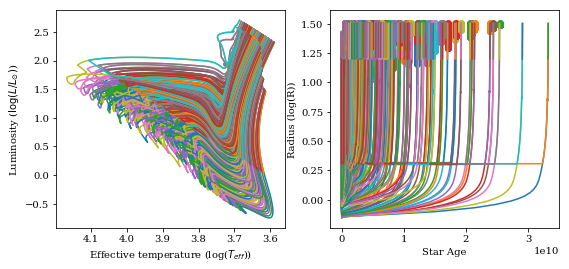

Choose value of intial mass, helium fraction and metallicity


In [5]:
Mass = {'0.8':'08', '1.0':'10', '1.2':'12', '1.4':'14', '1.6':'16', '1.8':'18'}
HeFrac = {'0.24':'024', '0.26':'026', '0.28':'028', '0.32':'032', '0.36':'036', '0.40':'040'}
Mets = {'-1.20':'-120', '-0.60':'-060', '-0.30':'-030', '-0.15':'-015', '0.00':'+000', '0.15':'+015'}

mass = None
He = None
met = None

output = ''

msg = 'Showing all ' +str(len(starIPs))+ ' tracks. Please wait a moment.'

plotting(mass, He, met, msg)

def mass_button_click(b):
    global mass
    mass = b.description
    msg = 'Showing only '+str(b.description)+' solar mass stars.'
    plotting(mass, He, met, msg)

def He_button_click(b):
    global He
    He = b.description
    msg = 'Showing only stars with '+str(b.description)+' initial helium fraction.'
    plotting(mass, He, met, msg)

def Met_button_click(b):
    global met
    met = b.description
    msg = 'Showing only stars with '+str(b.description)+' metallicity.'
    plotting(mass, He, met, msg)

massbuttons = []
Hebuttons = []
Metbuttons = []
print('Choose value of intial mass, helium fraction and metallicity')
for i, j in zip(Mass, range(len(Mass))):
    massbuttons.append(Button(description = i))
    massbuttons[j].on_click(mass_button_click)
for i, j in zip(HeFrac, range(len(HeFrac))):
    Hebuttons.append(Button(description = i))
    Hebuttons[j].on_click(He_button_click)
for i, j in zip(Mets, range(len(Mets))):
    Metbuttons.append(Button(description = i))
    Metbuttons[j].on_click(Met_button_click)
    
left_box = VBox([massbuttons[i] for i in range(len(Mass))])
mid_box = VBox([Hebuttons[i] for i in range(len(HeFrac))])
right_box = VBox([Metbuttons[i] for i in range(len(Mets))])
HBox([left_box, mid_box, right_box])

### Can choose parameters again.
    
    This time 3 need to be chosen to produce an echelle.

Choose mass, helium fraction and metallicity:


Mass = 1.8
Helium Fraction = 0.40
Metallicity = 0.15
Mean frequency spacing for these starting parameters is 5.903615374117575 micro Hz
Showing stan-fitted stars with mass between 1.5 and 2.1 solar masses.
Showing stan-fitted stars with metallicity between 0.0 and 0.3 log(Metsolar).


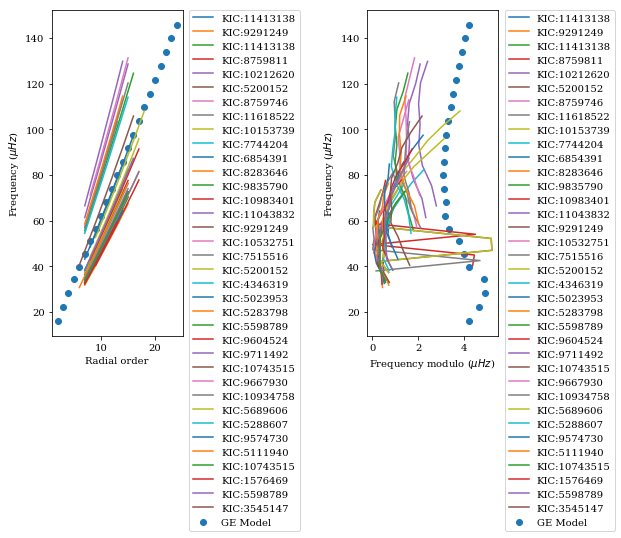

Mass = 1.6
Helium Fraction = 0.40
Metallicity = 0.15
Mean frequency spacing for these starting parameters is 16.731523513862747 micro Hz
Showing stan-fitted stars with mass between 1.3 and 1.9000000000000001 solar masses.
Showing stan-fitted stars with metallicity between 0.0 and 0.3 log(Metsolar).


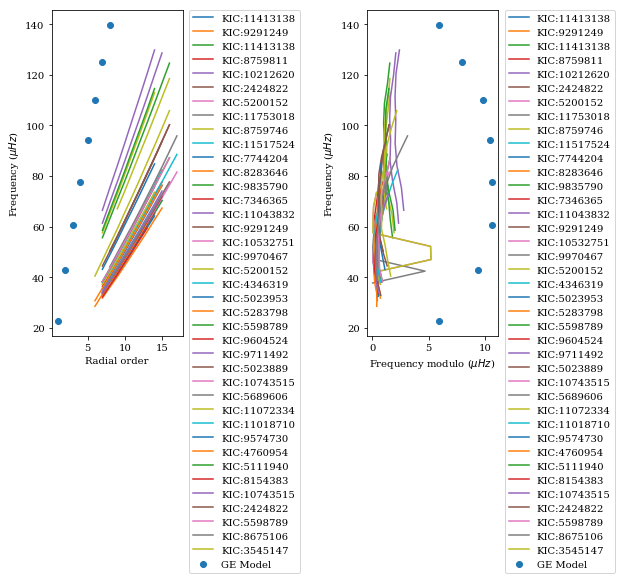

Mass = 1.4
Helium Fraction = 0.40
Metallicity = 0.15
Mean frequency spacing for these starting parameters is 10.52437484277649 micro Hz
Showing stan-fitted stars with mass between 1.0999999999999999 and 1.7 solar masses.
Showing stan-fitted stars with metallicity between 0.0 and 0.3 log(Metsolar).


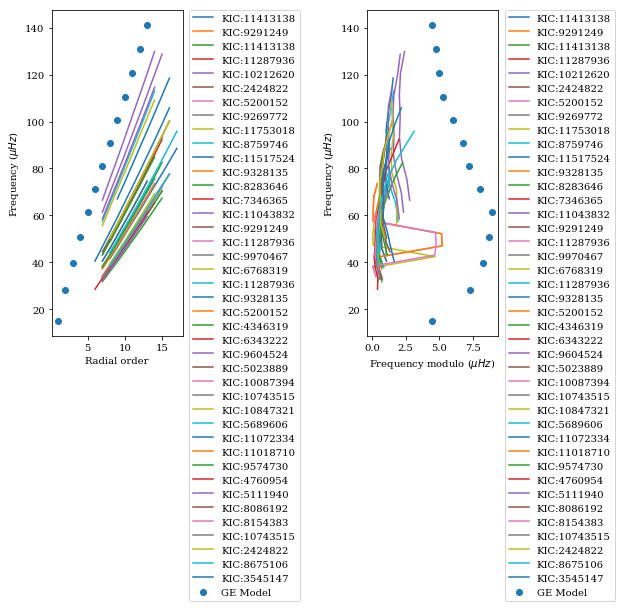

In [9]:
#%matplotlib notebook
txt_files = {}
files = [glob.glob(dirr + i + '/*.txt') for i in starIPs]
txt_files = dict((starIPs[i], pd.read_csv(str(files[i][0]), skiprows=5, delim_whitespace=True)) for i in range(len(starIPs)))

masbuttons = []
Hbuttons = []
Mtbuttons = []
mas=None
H=None
mt=None

def echelle(mas, H, mt):
    if mas != None and H != None and mt != None:
        df_toplot = df_stanstars.loc[(df_stanstars['IMass'] <= float(mas)+0.3) & (df_stanstars['IMass'] >= float(mas)-0.3) & 
                                     (df_stanstars['Metallicity'] <= float(mt)+0.15) & (df_stanstars['Metallicity'] >= float(mt)-0.15)]
        
        #print(df_toplot.empty)
        
        df_is_empty = True
        if df_toplot.empty:
            df_is_empty = False
        
        print('Mass = '+ str(mas))
        print('Helium Fraction = '+ str(H))
        print('Metallicity = ' + str(mt))
        file_name = 'm'+ str(Mass[mas]) + 'y' + str(HeFrac[H]) + 'z' + str(Mets[mt])
        file = txt_files[file_name]
        
        if df_is_empty:
            ns = {}
            for i in range(len(df_toplot.KIC)):
                an = np.arange(df_toplot.loc[(df_toplot['KIC'] == df_toplot.KIC.values[i])].nmin.values[0], 
                               df_toplot.loc[(df_toplot['KIC'] == df_toplot.KIC.values[i])].nmax.values[0]+1)
                ns[str(df_toplot.KIC.values[i])] = an
            
        
        dnuavg = np.mean(np.diff(file['Re(freq)']))
        print(r'Mean frequency spacing for these starting parameters is ' + str(dnuavg) + ' micro Hz')
        
        if df_is_empty:
            print('Showing stan-fitted stars with mass between '+ str(float(mas)-0.3) +
                  ' and ' + str(float(mas)+0.3) + ' solar masses.') 
            print('Showing stan-fitted stars with metallicity between '+ str(float(mt)-0.15) +
                  ' and ' + str(float(mt)+0.15) + ' log(Metsolar).') 
        else:
            print('No stan-fitted stars with similar mass or metallicity :(')
        plt.figure(3, figsize=(8,6))
        plt.subplot(131)
        plt.scatter(file['n_pg'], file['Re(freq)'], label='GE Model')
        
        if df_is_empty:
            nmin = []
            nmax = []
            for x in df_toplot.KIC.values:
                g = model(ns[str(x)], df_toplot.loc[(df_toplot['KIC'] == x)].dnu.values[0],
                          df_toplot.loc[(df_toplot['KIC'] == x)].numax.values[0], df_toplot.loc[(df_toplot['KIC'] == x)].epsilon.values[0],
                          df_toplot.loc[(df_toplot['KIC'] == x)].alpha.values[0], df_toplot.loc[(df_toplot['KIC'] == x)].A.values[0],
                          df_toplot.loc[(df_toplot['KIC'] == x)].G.values[0], df_toplot.loc[(df_toplot['KIC'] == x)].phi.values[0],
                          df_toplot.loc[(df_toplot['KIC'] == x)].tau.values[0])
                plt.plot(ns[str(x)], g, label='KIC:'+str(x))
                nmin.append(min(ns[str(x)]))
                nmax.append(max(ns[str(x)]))
            #plt.xlim([min(nmin),max(nmax)])
        plt.xlabel('Radial order')
        plt.ylabel('Frequency ($\mu Hz$)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.subplot(133)
        plt.scatter(file['Re(freq)'] % dnuavg, file['Re(freq)'], label='GE Model')
        
        if df_is_empty:
            emin = []
            emax = []
            for x in df_toplot.KIC.values:
                g = model(ns[str(x)], df_toplot.loc[(df_toplot['KIC'] == x)].dnu.values[0],
                          df_toplot.loc[(df_toplot['KIC'] == x)].numax.values[0], df_toplot.loc[(df_toplot['KIC'] == x)].epsilon.values[0],
                          df_toplot.loc[(df_toplot['KIC'] == x)].alpha.values[0], df_toplot.loc[(df_toplot['KIC'] == x)].A.values[0],
                          df_toplot.loc[(df_toplot['KIC'] == x)].G.values[0], df_toplot.loc[(df_toplot['KIC'] == x)].phi.values[0],
                          df_toplot.loc[(df_toplot['KIC'] == x)].tau.values[0])
                plt.plot(g % df_toplot.loc[(df_toplot['KIC'] == x)].dnu.values[0], g, label='KIC:'+str(x))
                emin.append(min(g % df_toplot.loc[(df_toplot['KIC'] == x)].dnu.values[0]))
                emax.append(max(g % df_toplot.loc[(df_toplot['KIC'] == x)].dnu.values[0]))
            #plt.xlim([min(emin),max(emax)])
        plt.ylabel('Frequency ($\mu Hz$)')
        plt.xlabel('Frequency modulo ($\mu Hz$)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

def mas_button_click(b):
    global mas
    mas = b.description
    echelle(mas, H, mt)    

def H_button_click(b):
    global H
    H = b.description
    echelle(mas, H, mt)

def Mt_button_click(b):
    global mt
    mt = b.description
    echelle(mas, H, mt)
    
print('Choose mass, helium fraction and metallicity:')
for i, j in zip(Mass, range(len(Mass))):
    masbuttons.append(Button(description = i))
    masbuttons[j].on_click(mas_button_click)

for i, j in zip(HeFrac, range(len(HeFrac))):
    Hbuttons.append(Button(description = i))
    Hbuttons[j].on_click(H_button_click)

for i, j in zip(Mets, range(len(Mets))):
    Mtbuttons.append(Button(description = i))
    Mtbuttons[j].on_click(Mt_button_click)

left_box = VBox([masbuttons[i] for i in range(len(Mass))])
mid_box = VBox([Hbuttons[i] for i in range(len(HeFrac))])
right_box = VBox([Mtbuttons[i] for i in range(len(Mets))])
HBox([left_box, mid_box, right_box])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


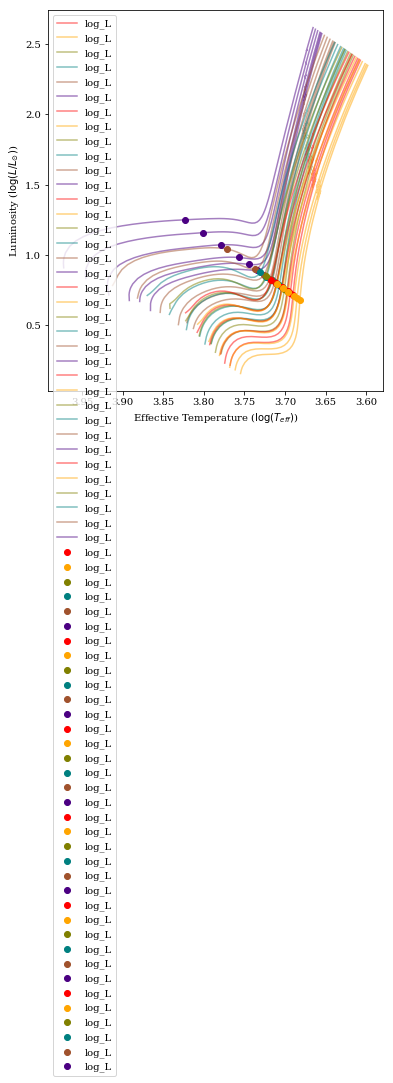

In [10]:
#folder = "~/Documents/mesa/models/"
#files = sorted(os.listdir('/home/daniel/Documents/mesa/models/'))
#dfs = [pd.read_csv(folder+str(i), skiprows=5, delim_whitespace=True) for i in files]

folders = sorted(os.listdir(dirr))
#print(folders)
files = [glob.glob(dirr + i + '/*.data') for i in folders]
profs = [glob.glob(dirr + i + '/*.index') for i in folders]
import itertools
colours = itertools.cycle(('r', 'orange', 'olive', 'teal', 'sienna', 'indigo'))#, 'black'))
## Need to develop tool for taking Y values and masses and allocating colours/linestyles (to-do)

Y = 0.24
M = 1.0


plt.figure(1, figsize=(6,7))
for i,j in zip(files, profs):
    df = pd.read_csv(i[0], skiprows=5, delim_whitespace=True)
    df = df.loc[(df.he_core_mass != 0.0)]
    dg = pd.read_csv(j[0], skiprows=1,
                  names=['model', 'priority', 'profile'], delim_whitespace=True)
    dg = dg.loc[(dg.priority == 1) & (dg.profile == 4)]['model']
    pt = dg.values
    #print(str(i[0][16:18]))
    if not pt:
        continue
    else:
        if str(i[0][16:18]) == str(Mass[str(M)]): #str(i[0][42:45])
            colour = next(colours)
            label = 'model '+str(int(pt))
            plt.scatter(df.loc[(df.model_number == int(pt))]['log_Teff'],
                    df.loc[(df.model_number == int(pt))]['log_L'], c=colour, label=label)
            #label = str(i[0][19:21])
            #label = str(i[0][42:45])
            plt.plot(df['log_Teff'], df['log_L'], c=colour, zorder=0,
                     alpha=0.5) #label=label)
    
    
plt.gca().invert_xaxis()
plt.xlabel(r'Effective Temperature ($\log(T_{eff})$)')
plt.ylabel(r'Luminosity ($\log(L/L_{\odot})$)')
#plt.legend(['0.24', '0.26', '0.28', '0.32', '0.36', '0.40'], title=r'$Y_{init}$')
plt.legend()
plt.show()
